# Raw vs L1-normalised spectrum plots (same workflow)
This notebook keeps the **same plotting workflow as your raw version**, and adds an L1 normalisation preprocessing option.

**Do not change your data path.** Keep your own CSV loading cell as-is. Just ensure it creates a DataFrame named `data`.


## 0) Load your data (KEEP YOUR EXISTING CELL)
Paste/keep your own CSV loading cell here. It must create a DataFrame called `data`.


In [2]:
from pathlib import Path
import re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("../../Data")  # folder next to this notebook
print("DATA_DIR:", DATA_DIR.resolve())

# Find CSVs (datasheet1.csv, datasheet2.csv, ... or any .csv in subfolders)
csv_paths = sorted([Path(p) for p in glob.glob(str(DATA_DIR / "**" / "*.csv"), recursive=True)])
print("Found CSVs:", len(csv_paths))
for p in csv_paths:
    print(" -", p)
# Load all data with filename-based metadata
frames = []
for path in csv_paths:
    df = pd.read_csv(path)
    df["__file__"] = path.name
    df["__path__"] = str(path)
    df["cuvette_id"] = path.stem
    frames.append(df)

data = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
print("Combined shape:", data.shape)
display(data.head())


DATA_DIR: D:\Cambridge_Sensor_CDT\Principle_of_Sensing_CW\Data
Found CSVs: 3
 - ..\..\Data\dataset1.csv
 - ..\..\Data\dataset2.csv
 - ..\..\Data\dataset3.csv
Combined shape: (81, 18)


,timestamp,juice_type,concentration,avg_ch1,avg_ch2,avg_ch3,avg_ch4,avg_ch5,avg_ch6,avg_ch7,avg_ch8,avg_ch9,avg_ch10,avg_ch11,avg_ch12,__file__,__path__,cuvette_id
0,2025-12-13T12:17:07,grape1,high,5.0,57.0,105.0,51.0,127.0,73.0,392.6,533.8,591.0,327.0,47.0,37.8,dataset1.csv,..\..\Data\dataset1.csv,dataset1
1,2025-12-13T12:19:05,grape1,medium,19.0,297.0,555.0,237.0,689.4,341.0,1348.0,1377.4,1131.2,529.0,70.0,71.4,dataset1.csv,..\..\Data\dataset1.csv,dataset1
2,2025-12-13T12:20:36,grape1,low,46.0,827.0,1490.0,592.2,1766.6,787.8,2797.6,2435.4,1694.2,733.6,96.0,110.2,dataset1.csv,..\..\Data\dataset1.csv,dataset1
3,2025-12-13T12:39:19,grape2,low,150.6,1647.0,2529.6,955.0,1964.8,985.0,3593.4,3405.2,2493.8,1114.2,220.6,259.4,dataset1.csv,..\..\Data\dataset1.csv,dataset1
4,2025-12-13T12:41:25,grape2,medium,33.0,568.4,853.0,279.8,425.6,270.0,1518.6,1936.2,1833.8,842.2,111.0,114.0,dataset1.csv,..\..\Data\dataset1.csv,dataset1


## 1) Label normalisation (juice_base / brand / cuvette)
Matches your format: `juice_type` like `orange1`, `grape2` etc.


In [3]:

import re
import pandas as pd

def normalise_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    required = ["juice_type", "concentration", "cuvette_id"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}. Available: {list(df.columns)}")

    jt = df["juice_type"].astype(str).str.strip().str.lower()
    conc = df["concentration"].astype(str).str.strip().str.lower()
    cuv = df["cuvette_id"].astype(str).str.strip().str.lower()

    df["juice_base"] = jt.str.extract(r"^([a-z]+)", expand=False).fillna(jt)
    df["brand"] = jt.str.extract(r"(\d+)$", expand=False).fillna("unknown")
    df["concentration"] = conc.replace({
        "med": "medium", "mid": "medium",
        "hi": "high", "h": "high",
        "lo": "low", "l": "low",
    })
    df["cuvette"] = cuv
    return df

data = normalise_labels(data)

print("juice_base:", sorted(data["juice_base"].unique()))
print("brand:", sorted(data["brand"].unique()))
print("cuvette:", sorted(data["cuvette"].unique()))
print("concentration:", sorted(data["concentration"].unique()))


juice_base: ['apple', 'grape', 'orange']
brand: ['1', '2', '3']
cuvette: ['dataset1', 'dataset2', 'dataset3']
concentration: ['high', 'low', 'medium']


## 2) Feature columns + fixed colours

In [4]:

import numpy as np
import matplotlib.pyplot as plt

def guess_feature_columns(df):
    cols = [c for c in df.columns if re.match(r"avg_ch\d+$", str(c))]
    cols = sorted(cols, key=lambda x: int(re.findall(r"\d+", x)[0]))
    if not cols:
        raise ValueError("No avg_ch* columns found.")
    return cols

feat_cols = guess_feature_columns(data)
print("Feature columns:", feat_cols)

# Fixed colours (as you requested)
JUICE_COLORS = {
    "grape": "purple",
    "apple": "red",
    "orange": "orange",
}


Feature columns: ['avg_ch1', 'avg_ch2', 'avg_ch3', 'avg_ch4', 'avg_ch5', 'avg_ch6', 'avg_ch7', 'avg_ch8', 'avg_ch9', 'avg_ch10', 'avg_ch11', 'avg_ch12']


## 3) Preprocess: L1 normalisation
For each sample, divide every channel by the sum of all 12 channels:
$$x_i' = x_i / \sum_j x_j$$


In [5]:

def l1_normalise_matrix(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    row_sum = X.sum(axis=1, keepdims=True)
    row_sum = np.where(row_sum == 0, eps, row_sum)
    return X / row_sum


## 4) One plotting function (same filters), with a `preprocess` switch
- `preprocess='raw'`: raw intensities
- `preprocess='l1'`: L1-normalised spectra


In [6]:

import pandas as pd

def _to_list(x):
    if x is None:
        return None
    if isinstance(x, (list, tuple, set)):
        return list(x)
    return [x]

def _print_choices(df):
    print("Available choices:")
    print("  juice_base:", sorted(df["juice_base"].astype(str).unique()))
    print("  brand     :", sorted(df["brand"].astype(str).unique()))
    print("  cuvette   :", sorted(df["cuvette"].astype(str).unique()))
    print("  concentration:", sorted(df["concentration"].astype(str).unique()))

def plot_spectra(
    df: pd.DataFrame,
    feat_cols,
    juice_base=None,
    concentration=None,
    brand=None,
    cuvette=None,
    overlay="juice_base",      # "juice_base"/"concentration"/"brand"/"cuvette"
    agg="mean",                # "mean"/"median"/None
    preprocess="raw",          # "raw" or "l1"
    show_mean=True,            # used when agg=None
    alpha=0.25,
    title=None,
    figsize=(10,4),
):
    d = df.copy()
    for col in ["juice_base", "concentration", "brand", "cuvette"]:
        d[col] = d[col].astype(str)

    def apply_filter(col, val):
        nonlocal d
        vals = _to_list(val)
        if vals is None:
            return
        vals = [str(v) for v in vals]
        d = d[d[col].isin(vals)]

    apply_filter("juice_base", juice_base)
    apply_filter("concentration", concentration)
    apply_filter("brand", brand)
    apply_filter("cuvette", cuvette)

    if d.empty:
        print("No rows matched your filters.")
        _print_choices(df)
        print("\nYour filters were:")
        print("  juice_base=", juice_base, "| concentration=", concentration, "| brand=", brand, "| cuvette=", cuvette)
        return

    if overlay not in d.columns:
        raise ValueError(f"overlay='{overlay}' not in columns: {list(d.columns)}")

    X = d[feat_cols].to_numpy(dtype=float)
    if preprocess.lower() in ("l1", "l1norm", "l1_normalised", "l1_normalized"):
        Xp = l1_normalise_matrix(X)
        ylabel = "fraction of total (L1 normalised)"
    elif preprocess.lower() == "raw":
        Xp = X
        ylabel = "intensity (raw)"
    else:
        raise ValueError("preprocess must be 'raw' or 'l1'")

    print(f"Rows plotted: {len(d)} | overlay={overlay} | agg={agg} | preprocess={preprocess}")

    fig, ax = plt.subplots(figsize=figsize)

    for key, idx in d.groupby(overlay).groups.items():
        key = str(key)
        Xi = Xp[list(idx), :]

        color = JUICE_COLORS.get(key, None) if overlay == "juice_base" else None

        if agg in ("mean", "median"):
            y = Xi.mean(axis=0) if agg == "mean" else np.median(Xi, axis=0)
            ax.plot(range(len(feat_cols)), y, marker="o", label=key, color=color)
        elif agg is None:
            for r in range(Xi.shape[0]):
                ax.plot(range(len(feat_cols)), Xi[r], color=color, alpha=alpha)
            if show_mean:
                y = Xi.mean(axis=0)
                ax.plot(range(len(feat_cols)), y, marker="o", label=f"{key} (mean)", color=color)
        else:
            raise ValueError("agg must be 'mean', 'median', or None")

    ax.set_xlabel("channel index")
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(feat_cols)))
    ax.set_xticklabels([re.findall(r"\d+", c)[0] for c in feat_cols])
    ax.legend()

    if title is None:
        title = f"{preprocess} spectra | filters: juice={juice_base}, conc={concentration}, brand={brand}, cuvette={cuvette}"
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


## 5) Example calls
Same as raw, just switch `preprocess`.


In [7]:
def plot_spectra(
    df,
    feat_cols,
    juice_base=None,
    concentration=None,
    brand=None,
    cuvette=None,
    overlay="juice_base",     # "juice_base" / "concentration" / "brand" / "cuvette"
    agg="mean",               # "mean" / "median" / None
    preprocess="raw",         # "raw" / "l1"
    show_mean=True,
    alpha=0.25,
    title=None,
    figsize=(10,4),
):
    d = df.copy()

    # --- 确保这些列存在
    required_cols = ["juice_base", "brand", "cuvette", "concentration"]
    for c in required_cols:
        if c not in d.columns:
            raise KeyError(f"Missing column '{c}'. Available: {list(d.columns)}")

    # --- 全部转成字符串，防止 1 vs '1'
    for col in required_cols:
        d[col] = d[col].astype(str)

    # --- apply filters
    def _to_list(x):
        if x is None:
            return None
        if isinstance(x, (list, tuple, set)):
            return [str(v) for v in x]
        return [str(x)]

    def apply_filter(col, val):
        nonlocal d
        vals = _to_list(val)
        if vals is None:
            return
        d = d[d[col].isin(vals)]

    apply_filter("juice_base", juice_base)
    apply_filter("concentration", concentration)
    apply_filter("brand", brand)
    apply_filter("cuvette", cuvette)

    if d.empty:
        print("No rows matched your filters.")
        print("Available choices:")
        print("  juice_base:", sorted(df["juice_base"].astype(str).unique()) if "juice_base" in df.columns else "N/A")
        print("  brand     :", sorted(df["brand"].astype(str).unique()) if "brand" in df.columns else "N/A")
        print("  cuvette   :", sorted(df["cuvette"].astype(str).unique()) if "cuvette" in df.columns else "N/A")
        print("  concentration:", sorted(df["concentration"].astype(str).unique()) if "concentration" in df.columns else "N/A")
        return

    # ✅ 关键修复：重置 index，让 groupby 的索引和 Xp 对齐
    d = d.reset_index(drop=True)

    # --- build matrix X
    X = d[feat_cols].to_numpy(dtype=float)

    # --- preprocess
    if preprocess == "raw":
        Xp = X
        y_label = "intensity (raw)"
    elif preprocess == "l1":
        row_sum = np.nansum(X, axis=1, keepdims=True)
        row_sum[row_sum == 0] = np.nan
        Xp = X / row_sum
        y_label = "fraction of total (L1)"
    else:
        raise ValueError("preprocess must be 'raw' or 'l1'")

    if overlay not in d.columns:
        raise ValueError(f"overlay='{overlay}' not in columns: {list(d.columns)}")

    print(f"Rows plotted: {len(d)} | overlay={overlay} | agg={agg} | preprocess={preprocess}")

    fig, ax = plt.subplots(figsize=figsize)

    # --- plot per overlay group (idx now 0..n-1)
    for key, idx in d.groupby(overlay).groups.items():
        key = str(key)
        Xi = Xp[list(idx), :]

        color = JUICE_COLORS.get(key, None) if overlay == "juice_base" else None

        if agg in ("mean", "median"):
            if agg == "mean":
                y = np.nanmean(Xi, axis=0)
            else:
                y = np.nanmedian(Xi, axis=0)
            ax.plot(range(len(feat_cols)), y, marker="o", label=key, color=color)

        elif agg is None:
            # 画每条曲线
            for r in Xi:
                ax.plot(range(len(feat_cols)), r, color=color, alpha=alpha)
            if show_mean:
                y = np.nanmean(Xi, axis=0)
                ax.plot(range(len(feat_cols)), y, marker="o", label=f"{key} (mean)", color=color)
        else:
            raise ValueError("agg must be 'mean', 'median', or None")

    ax.set_xlabel("channel index")
    ax.set_ylabel(y_label)
    ax.legend()

    if title is None:
        title = f"{preprocess.upper()} | overlay={overlay}"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


Rows plotted: 3 | overlay=concentration | agg=mean | preprocess=raw


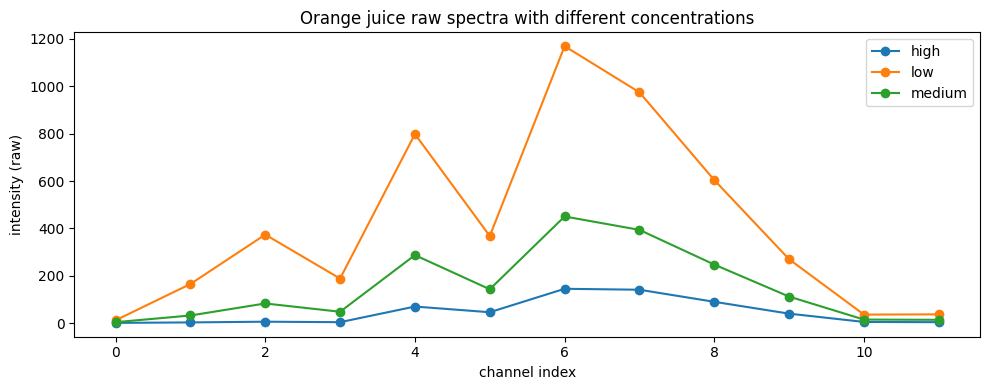

Rows plotted: 3 | overlay=concentration | agg=mean | preprocess=raw


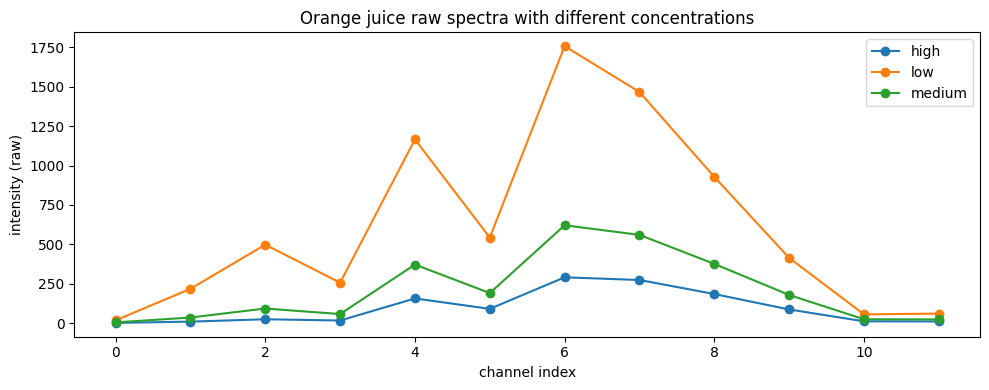

Rows plotted: 3 | overlay=concentration | agg=mean | preprocess=raw


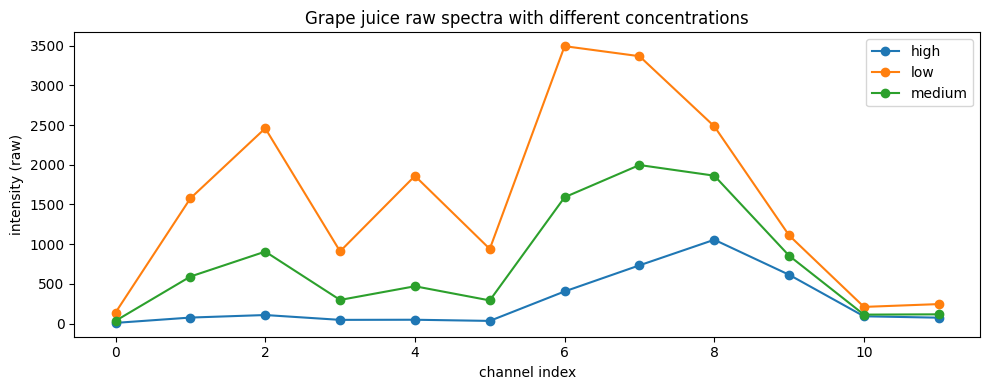

Rows plotted: 3 | overlay=concentration | agg=mean | preprocess=raw


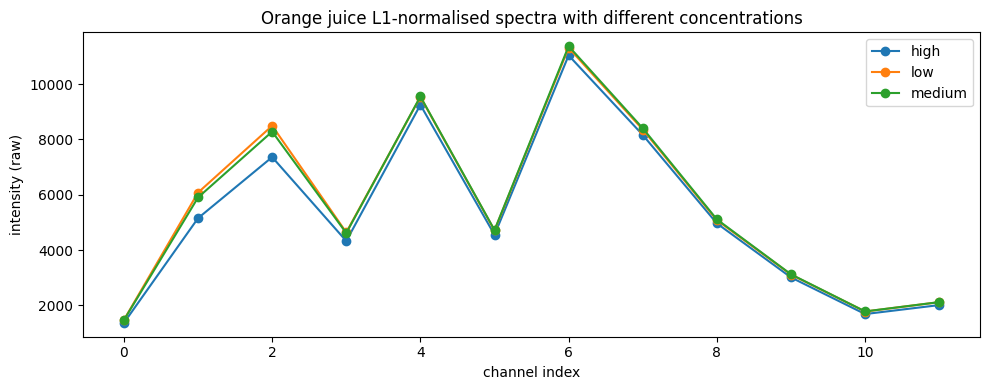

In [32]:

# Compare concentrations for a fixed juice+brand+cuvette (RAW vs L1)
plot_spectra(
    data, feat_cols,
    juice_base="orange",
    brand="1",
    cuvette="dataset1",
    overlay="concentration",
    agg="mean",
    preprocess="raw",
    title="Orange juice raw spectra with different concentrations"
)

plot_spectra(
    data, feat_cols,
    juice_base="orange",
    brand="2",
    cuvette="dataset1",
    overlay="concentration",
    agg="mean",
    preprocess="raw",
    title="Orange juice raw spectra with different concentrations"
)

plot_spectra(
    data, feat_cols,
    juice_base="grape",
    brand="2",
    cuvette="dataset3",
    overlay="concentration",
    agg="mean",
    preprocess="raw",
    title="Grape juice raw spectra with different concentrations"
)

plot_spectra(
    data, feat_cols,
    juice_base="apple",
    brand="1",
    cuvette="dataset1",
    overlay="concentration",
    agg="mean",
    preprocess="raw",
    title="Orange juice L1-normalised spectra with different concentrations"
)


Rows plotted: 3 | overlay=juice_base | agg=mean | preprocess=raw


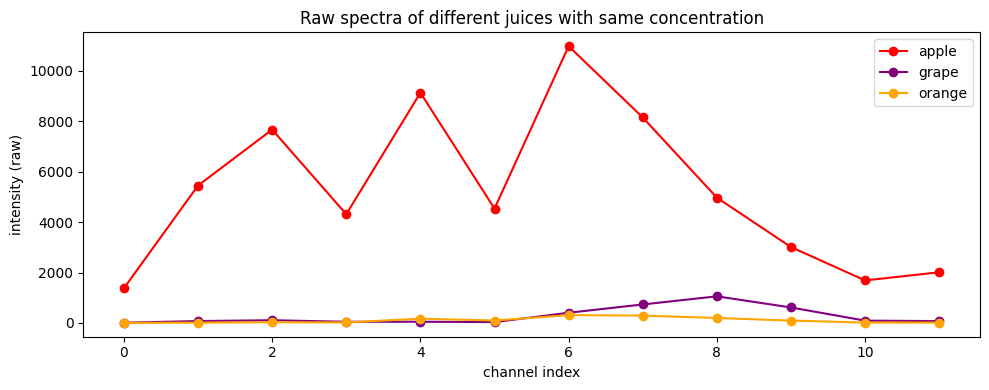

Rows plotted: 3 | overlay=juice_base | agg=mean | preprocess=l1


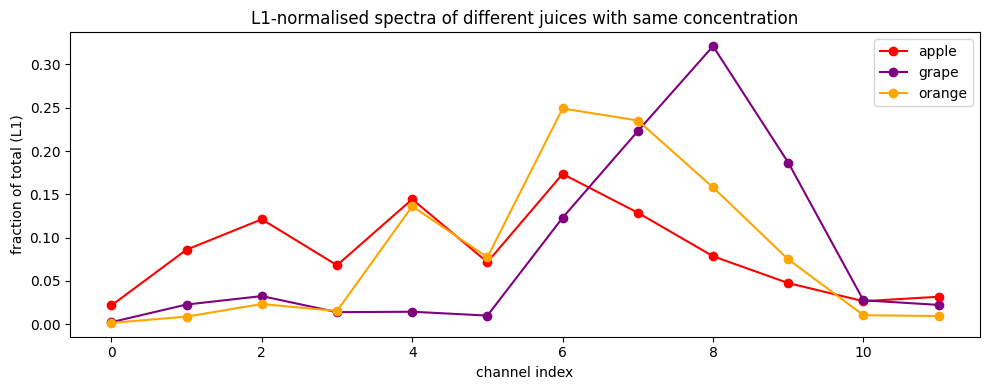

In [33]:
plot_spectra(data, feat_cols,
    concentration="high",
    cuvette="dataset3",
    brand="2",
    overlay="juice_base",
    agg="mean",
    preprocess="raw",
    title="Raw spectra of different juices with same concentration"
)

plot_spectra(data, feat_cols,
    concentration="high",
    cuvette="dataset3",
    brand="2",
    overlay="juice_base",
    agg="mean",
    preprocess="l1",
    title="L1-normalised spectra of different juices with same concentration"
)

Rows plotted: 3 | overlay=brand | agg=mean | preprocess=raw


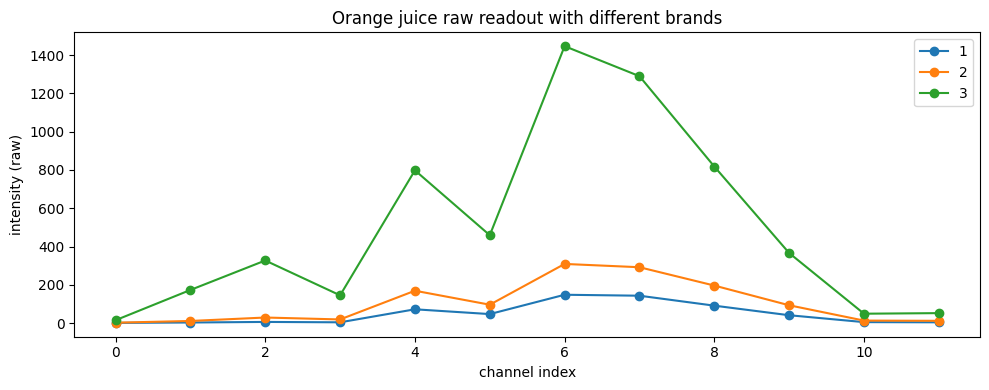

Rows plotted: 3 | overlay=brand | agg=mean | preprocess=l1


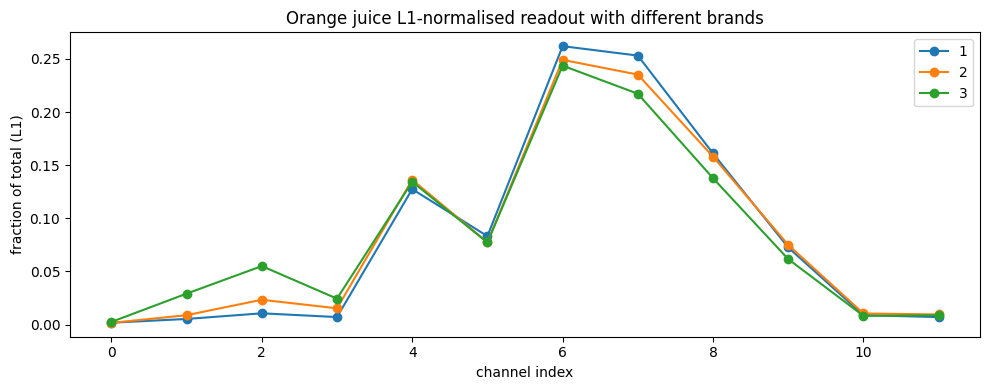

In [34]:
plot_spectra(
    data, feat_cols,
    juice_base="orange",
    concentration="high",
    cuvette="dataset3",      # 改成 dataset1 / dataset2 / dataset3
    overlay="brand",         # 每条线代表一个牌子
    agg="mean",
    preprocess="raw",        # 或 "l1"
    title="Orange juice raw readout with different brands"
)
plot_spectra(
    data, feat_cols,
    juice_base="orange",
    concentration="high",
    cuvette="dataset3",      # 改成 dataset1 / dataset2 / dataset3
    overlay="brand",         # 每条线代表一个牌子
    agg="mean",
    preprocess="l1",        # 或 "l1"
    title="Orange juice L1-normalised readout with different brands"
)


Rows plotted: 3 | overlay=brand | agg=mean | preprocess=raw


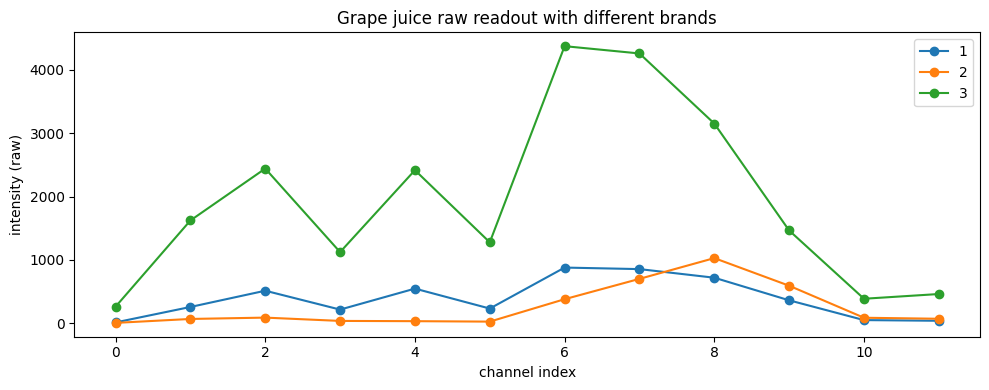

Rows plotted: 3 | overlay=brand | agg=mean | preprocess=l1


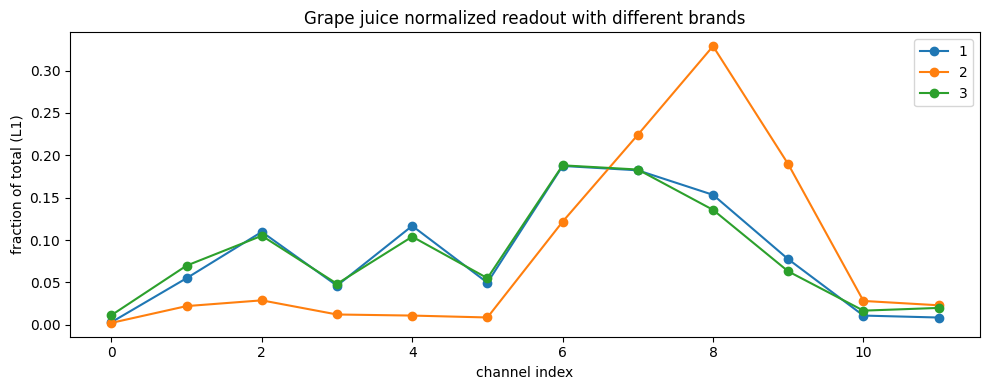

In [35]:
plot_spectra(
    data, feat_cols,
    juice_base="grape",
    concentration="high",
    cuvette="dataset2",      # 改成 dataset1 / dataset2 / dataset3
    overlay="brand",         # 每条线代表一个牌子
    agg="mean",
    preprocess="raw",        # 或 "l1"
    title="Grape juice raw readout with different brands"
)
plot_spectra(
    data, feat_cols,
    juice_base="grape",
    concentration="high",
    cuvette="dataset2",      # 改成 dataset1 / dataset2 / dataset3
    overlay="brand",         # 每条线代表一个牌子
    agg="mean",
    preprocess="l1",        # 或 "l1"
    title="Grape juice normalized readout with different brands"
)
